# Determining Sentence Sentiment using NLP

In [1]:
import torch
import pandas as pd

# My libraries
from src import Trainer, Plotter, DynamicRNN
from src import get_sst_data_loaders

# Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running experiments on hardware type: {DEVICE}")

Running experiments on hardware type: cuda


In [2]:
BATCH_SIZE = 64
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 5
DROPOUT = 0.5
EPOCHS = 15
LEARNING_RATE = 0.001

# Pre-trained Vector Path
VECTOR_PATH = "./data/vector.txt"

In [3]:
print("Initializing Data Pipeline...")

# 1. Call the new loader function
train_iter, val_iter, test_iter, TEXT_FIELD, LABEL_FIELD = get_sst_data_loaders(
    batch_size=BATCH_SIZE, vector_path=VECTOR_PATH, device=DEVICE
)

# 2. Extract Metadata from the returned Fields
VOCAB_SIZE = len(TEXT_FIELD.vocab)

# --- FIX: Access pad_token from the vocab object, not the field object ---
PAD_IDX = TEXT_FIELD.vocab.stoi.get(TEXT_FIELD.vocab.pad_token)

PRETRAINED_VECTORS = TEXT_FIELD.vocab.vectors

print(f"Data ready. Vocab Size: {VOCAB_SIZE}, Pad Index: {PAD_IDX}")
if PRETRAINED_VECTORS is not None:
    print(f"Embeddings shape: {PRETRAINED_VECTORS.shape}")

Initializing Data Pipeline...
--> Initializing Fields...
--> Loading SST Splits...
    Training samples: 8544
--> Building Vocabulary...
    Vocab Size: 18280
    Label Map: {'very negative': 1, 'negative': 2, 'neutral': 3, 'positive': 4, 'very positive': 5}
--> Building Iterators...
Data ready. Vocab Size: 18280, Pad Index: 1
Embeddings shape: torch.Size([18280, 300])


### Part 1: Find the best model

In [4]:
experiments_config = [
    # --- Naive RNN ---
    {
        "name": "1_RNN_Random",
        "rnn_type": "rnn",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "2_RNN_Pretrained",
        "rnn_type": "rnn",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    # --- Naive LSTM ---
    {
        "name": "3_LSTM_Random",
        "rnn_type": "lstm",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "4_LSTM_Pretrained",
        "rnn_type": "lstm",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    # --- Naive GRU ---
    {
        "name": "5_GRU_Random",
        "rnn_type": "gru",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "6_GRU_Pretrained",
        "rnn_type": "gru",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    # --- Better LSTM (Bi-Directional, 2 Layers) ---
    {
        "name": "7_BiLSTM_Deep_Random",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": False,
    },
    {
        "name": "8_BiLSTM_Deep_Pretrained",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
    },
    # --- Better GRU (Bi-Directional, 2 Layers) ---
    {
        "name": "9_BiGRU_Deep_Random",
        "rnn_type": "gru",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": False,
    },
    {
        "name": "10_BiGRU_Deep_Pretrained",
        "rnn_type": "gru",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
    },
]

In [5]:
# Store all results here
all_histories = {}  # Key: Model Name, Value: History Dict
all_summaries = []  # List of Summary Dicts for DataFrame

for config in experiments_config:
    print(f"\n{'='*20} Running: {config['name']} {'='*20}")

    # 1. Init Model
    model = DynamicRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=config["n_layers"],
        bidirectional=config["bidirectional"],
        dropout=DROPOUT,
        pad_idx=PAD_IDX,
        rnn_type=config["rnn_type"],
    )

    # 2. Embeddings
    if config["use_pretrained"]:
        if PRETRAINED_VECTORS is not None:
            print(f"Loading vectors...")
            model.embedding.weight.data.copy_(PRETRAINED_VECTORS)
        else:
            print("Vectors not found, using random.")

    # 3. Hyperparams for record keeping
    hyperparams = {
        "Type": config["rnn_type"].upper(),
        "BiDir": config["bidirectional"],
        "Embeds": "Pretrained" if config["use_pretrained"] else "Random",
        "Layers": config["n_layers"],
    }

    # 4. Train
    trainer = Trainer(model, DEVICE)
    history, summary = trainer.run_experiment(
        train_iter,
        val_iter,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        name=config["name"],
        hyperparameters=hyperparams,
        save_weights=True,
    )

    # 5. Store Data
    all_histories[config["name"]] = history
    all_summaries.append(summary)

print("\nAll models trained successfully.")


==================== Running: 1_RNN_Random ====================
Starting 1_RNN_Random | Params: 5,628,133
  Epoch: 01 | Time: 0m 0s | Train Acc: 0.247 | Val Acc: 0.283
  Epoch: 02 | Time: 0m 0s | Train Acc: 0.272 | Val Acc: 0.289
  Epoch: 03 | Time: 0m 0s | Train Acc: 0.300 | Val Acc: 0.306
  Epoch: 04 | Time: 0m 0s | Train Acc: 0.331 | Val Acc: 0.349
  Epoch: 05 | Time: 0m 0s | Train Acc: 0.363 | Val Acc: 0.346
  Epoch: 06 | Time: 0m 0s | Train Acc: 0.395 | Val Acc: 0.330
  Epoch: 07 | Time: 0m 0s | Train Acc: 0.417 | Val Acc: 0.354
  Epoch: 08 | Time: 0m 0s | Train Acc: 0.448 | Val Acc: 0.348
  Epoch: 09 | Time: 0m 0s | Train Acc: 0.474 | Val Acc: 0.336
  Epoch: 10 | Time: 0m 0s | Train Acc: 0.495 | Val Acc: 0.358
  Epoch: 11 | Time: 0m 0s | Train Acc: 0.519 | Val Acc: 0.370
  Epoch: 12 | Time: 0m 0s | Train Acc: 0.543 | Val Acc: 0.365
  Epoch: 13 | Time: 0m 0s | Train Acc: 0.557 | Val Acc: 0.334
  Epoch: 14 | Time: 0m 0s | Train Acc: 0.585 | Val Acc: 0.351
  Epoch: 15 | Time: 0m 0s

Generating plots for 10 models...



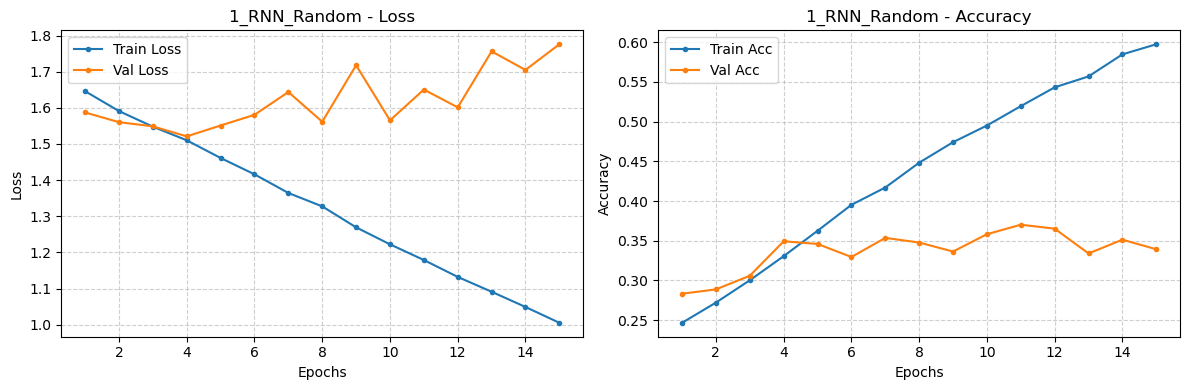

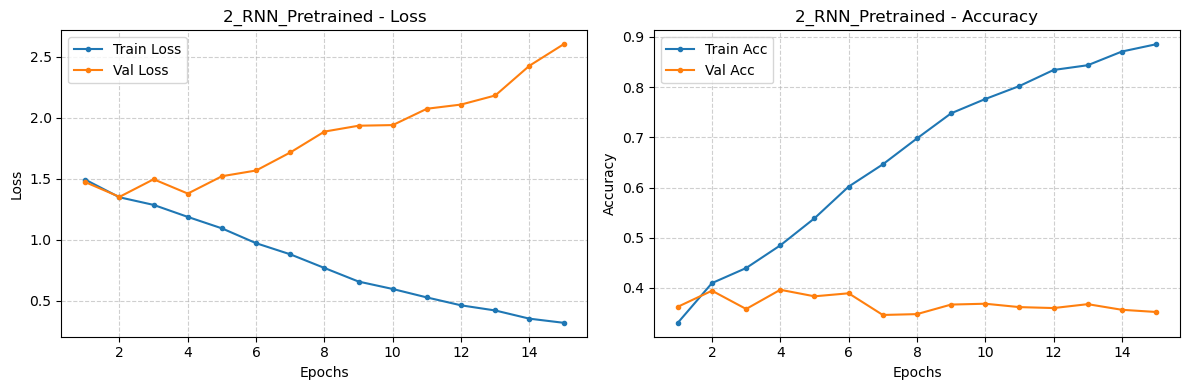

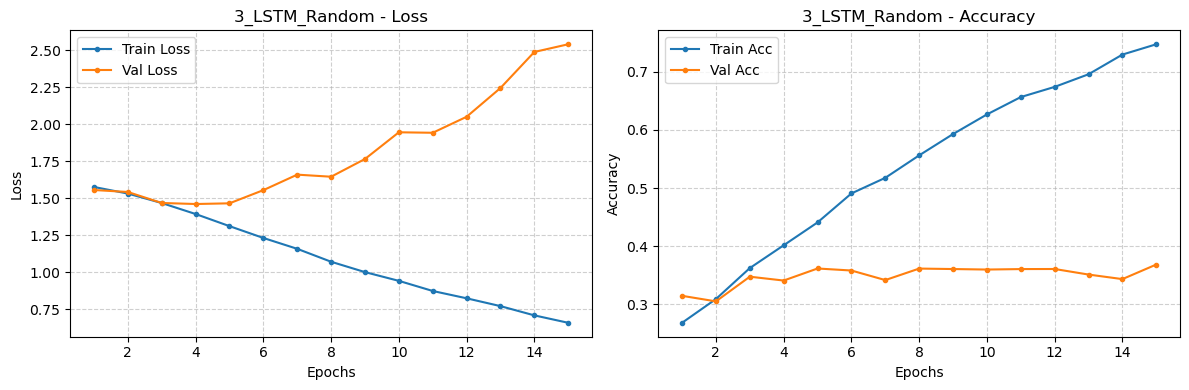

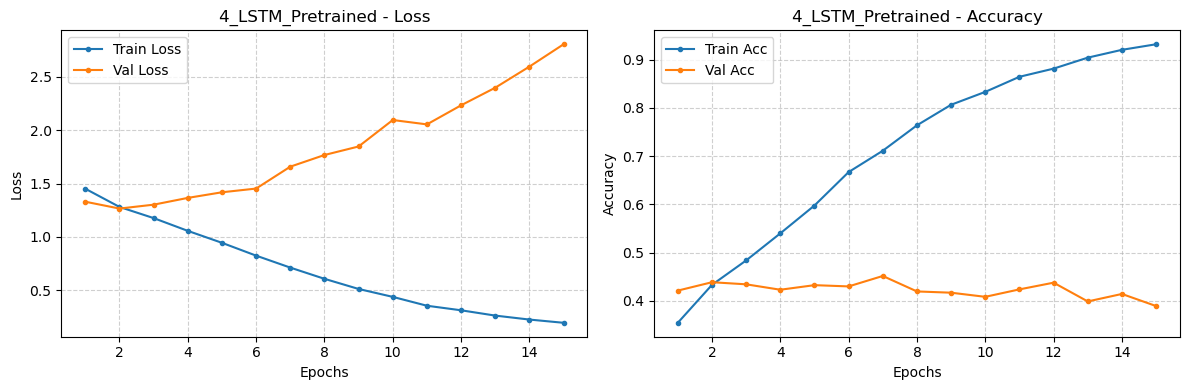

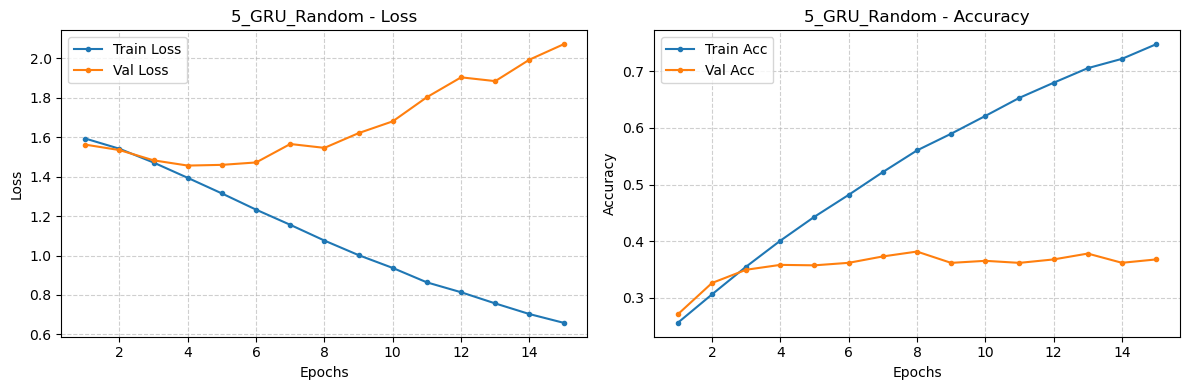

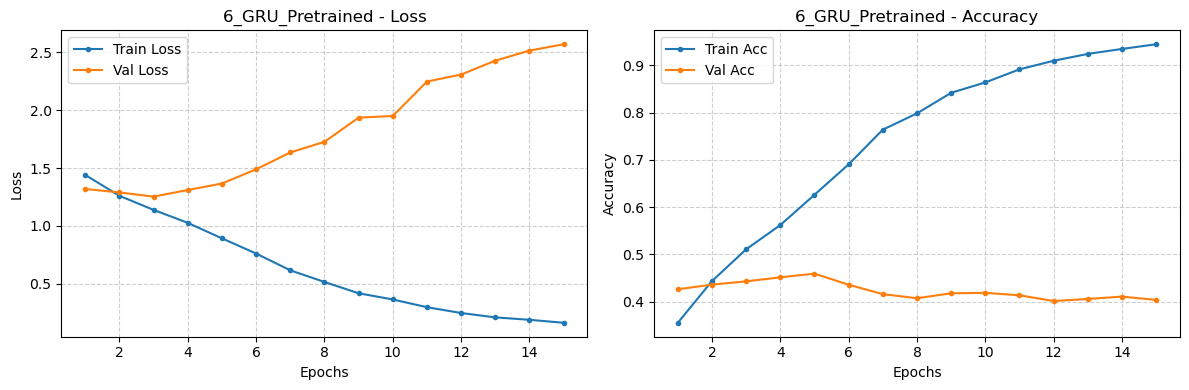

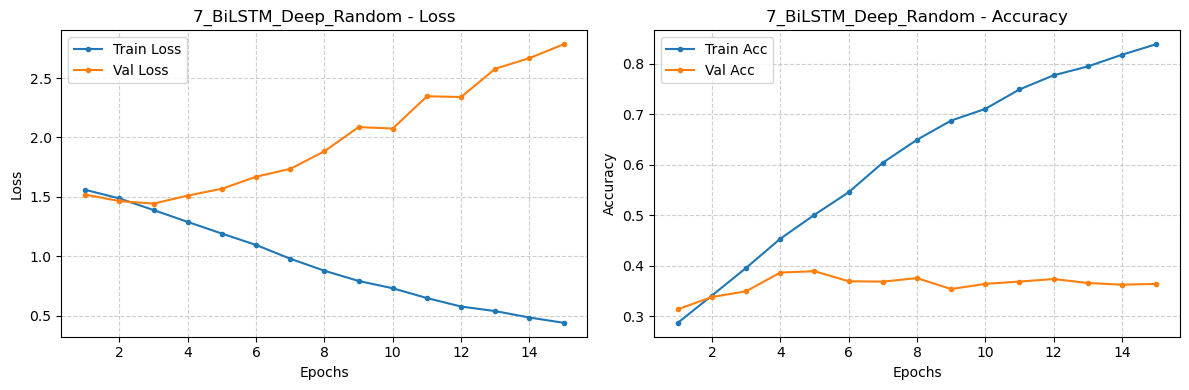

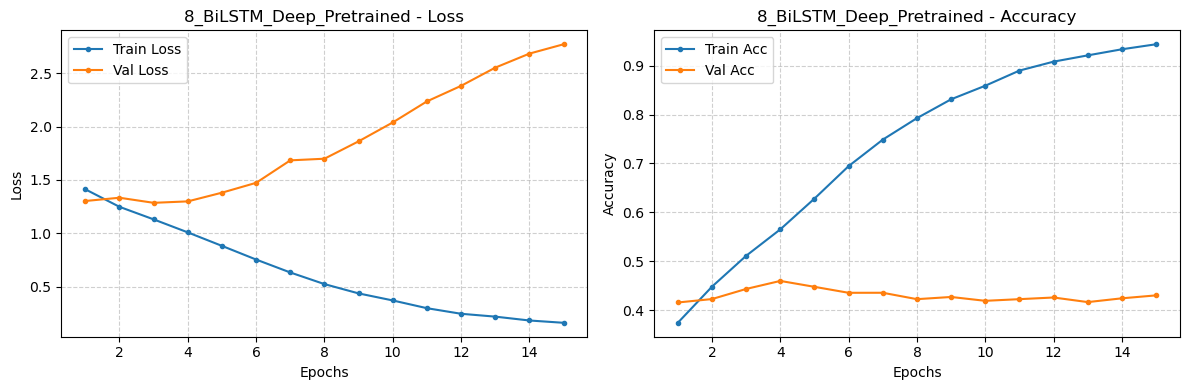

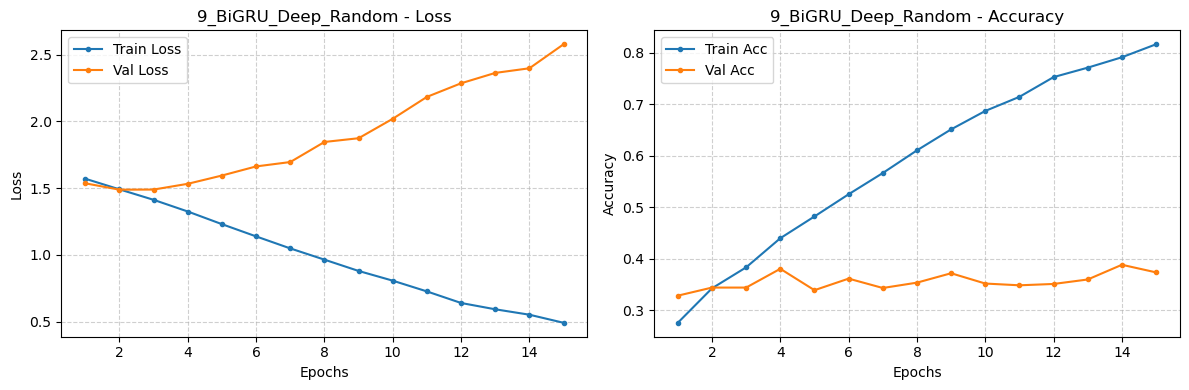

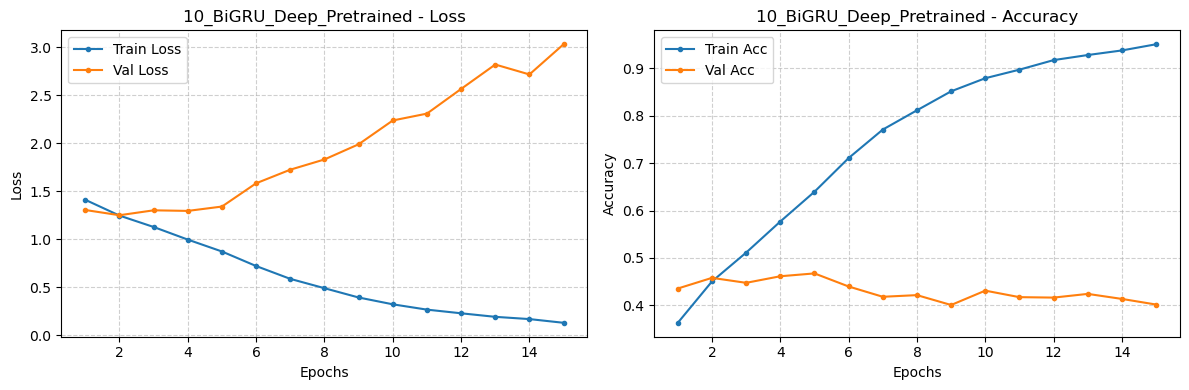

In [6]:
print(f"Generating plots for {len(all_histories)} models...\n")

for model_name, history in all_histories.items():
    Plotter.plot_history(history, title=model_name)

In [7]:
df_results = pd.DataFrame(all_summaries)

cols = [
    "Model",
    "Type",
    "BiDir",
    "Embeds",
    "Best Val Acc",
    "Best Val Loss",
    "Time (s)",
    "Parameters",
]
cols = [c for c in cols if c in df_results.columns]
df_results = df_results[cols + [c for c in df_results.columns if c not in cols]]

display(df_results.sort_values(by="Best Val Acc", ascending=False))

csv_path = "sst_experiment_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

,Model,Type,BiDir,Embeds,Best Val Acc,Best Val Loss,Time (s),Parameters,Layers,Train Loss,Train Acc,Val Loss,Val Acc
9,10_BiGRU_Deep_Pretrained,GRU,True,Pretrained,0.4673,1.2489,24.11,7526373,2,0.1287,0.9511,3.0295,0.4015
5,6_GRU_Pretrained,GRU,False,Pretrained,0.4595,1.2528,11.67,5913829,1,0.1611,0.9443,2.5706,0.4040
7,8_BiLSTM_Deep_Pretrained,LSTM,True,Pretrained,0.4595,1.2859,24.88,8206309,2,0.1620,0.9439,2.7713,0.4300
3,4_LSTM_Pretrained,LSTM,False,Pretrained,0.4517,1.2651,11.91,6056677,1,0.1936,0.9318,2.8062,0.3894
1,2_RNN_Pretrained,RNN,False,Pretrained,0.3964,1.3512,11.60,5628133,1,0.3197,0.8853,2.6013,0.3522
6,7_BiLSTM_Deep_Random,LSTM,True,Random,0.3893,1.4436,24.95,8206309,2,0.4402,0.8383,2.7848,0.3642
8,9_BiGRU_Deep_Random,GRU,True,Random,0.3885,1.4886,24.34,7526373,2,0.4906,0.8160,2.5791,0.3737
4,5_GRU_Random,GRU,False,Random,0.3816,1.4558,11.71,5913829,1,0.6591,0.7477,2.0707,0.3677
0,1_RNN_Random,RNN,False,Random,0.3702,1.5210,12.10,5628133,1,1.0052,0.5972,1.7758,0.3393
2,3_LSTM_Random,LSTM,False,Random,0.3685,1.4599,12.03,6056677,1,0.6569,0.7470,2.5398,0.3685


Results saved to sst_experiment_results.csv


## How can we improve our model?

In [8]:
phase3_experiments = [
    # The winner from Phase 2 (Frozen, No Attention)
    {
        "name": "Baseline_Winner",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": False,
        "freeze_embeddings": True,
    },
    # Optimization 1: Unfreeze Embeddings (Fine-Tuning)
    {
        "name": "FineTuned_Embeddings",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": False,
        "freeze_embeddings": False,  # <--- Unlocked
    },
    # Optimization 2: Add Attention (with frozen embeddings)
    {
        "name": "Attention_Frozen",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": True,
        "freeze_embeddings": True,  # <--- Attention ON
    },
    # Optimization 3: The "Kitchen Sink" (Attention + Fine-Tuning)
    {
        "name": "Best_Model_Full_Opt",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": True,
        "freeze_embeddings": False,  # <--- Both ON
    },
]

In [10]:
all_histories = {}  # Key: Model Name, Value: History Dict
all_summaries = []  # List of Summary Dicts for DataFrame

for config in phase3_experiments:
    print(f"\n{'='*20} Running: {config['name']} {'='*20}")

    # 1. Init Model
    # Note: We strictly force attention=False and freeze=True for valid Phase 1/2 comparison
    model = DynamicRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=config["n_layers"],
        bidirectional=config["bidirectional"],
        dropout=DROPOUT,
        pad_idx=PAD_IDX,
        rnn_type=config["rnn_type"],
        use_attention=False,  # Optimization reserved for Phase 3
        freeze_embeddings=True,  # We want to compare Random vs Static Pretrained first
    )

    # 2. Embeddings
    if config["use_pretrained"]:
        if PRETRAINED_VECTORS is not None:
            print(f"Loading vectors...")
            model.embedding.weight.data.copy_(PRETRAINED_VECTORS)
        else:
            print("Vectors not found, using random.")

    # 3. Hyperparams for record keeping
    hyperparams = {
        "Type": config["rnn_type"].upper(),
        "BiDir": config["bidirectional"],
        "Embeds": "Pretrained" if config["use_pretrained"] else "Random",
        "Layers": config["n_layers"],
    }

    # 4. Train
    trainer = Trainer(model, DEVICE)
    history, summary = trainer.run_experiment(
        train_iter,
        val_iter,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        name=config["name"],
        hyperparameters=hyperparams,
        save_weights=True,
    )

    # 5. Store Data
    all_histories[config["name"]] = history
    all_summaries.append(summary)

print("\nAll models trained successfully.")


==================== Running: Baseline_Winner ====================
Loading vectors...
Starting Baseline_Winner | Params: 2,722,309
  Epoch: 01 | Time: 0m 1s | Train Acc: 0.365 | Val Acc: 0.415
  Epoch: 02 | Time: 0m 1s | Train Acc: 0.420 | Val Acc: 0.433
  Epoch: 03 | Time: 0m 1s | Train Acc: 0.444 | Val Acc: 0.435
  Epoch: 04 | Time: 0m 1s | Train Acc: 0.453 | Val Acc: 0.436
  Epoch: 05 | Time: 0m 1s | Train Acc: 0.468 | Val Acc: 0.454
  Epoch: 06 | Time: 0m 1s | Train Acc: 0.492 | Val Acc: 0.438
  Epoch: 07 | Time: 0m 1s | Train Acc: 0.506 | Val Acc: 0.458
  Epoch: 08 | Time: 0m 1s | Train Acc: 0.514 | Val Acc: 0.461
  Epoch: 09 | Time: 0m 1s | Train Acc: 0.538 | Val Acc: 0.462
  Epoch: 10 | Time: 0m 1s | Train Acc: 0.565 | Val Acc: 0.457
  Epoch: 11 | Time: 0m 1s | Train Acc: 0.587 | Val Acc: 0.448
  Epoch: 12 | Time: 0m 1s | Train Acc: 0.589 | Val Acc: 0.451
  Epoch: 13 | Time: 0m 1s | Train Acc: 0.634 | Val Acc: 0.439
  Epoch: 14 | Time: 0m 1s | Train Acc: 0.654 | Val Acc: 0.437


Generating plots for 4 models...



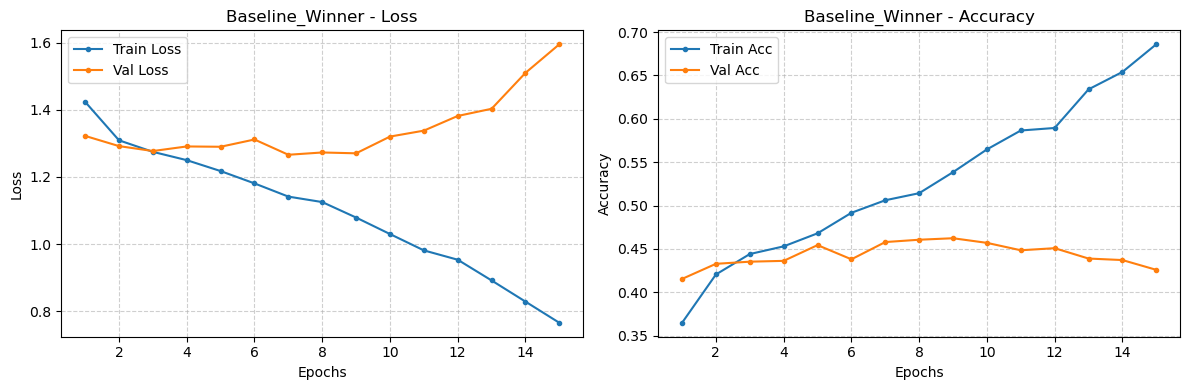

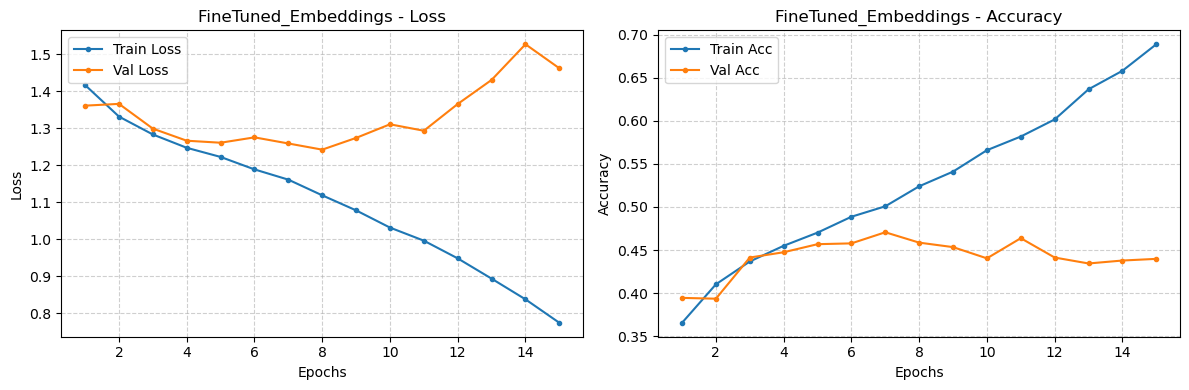

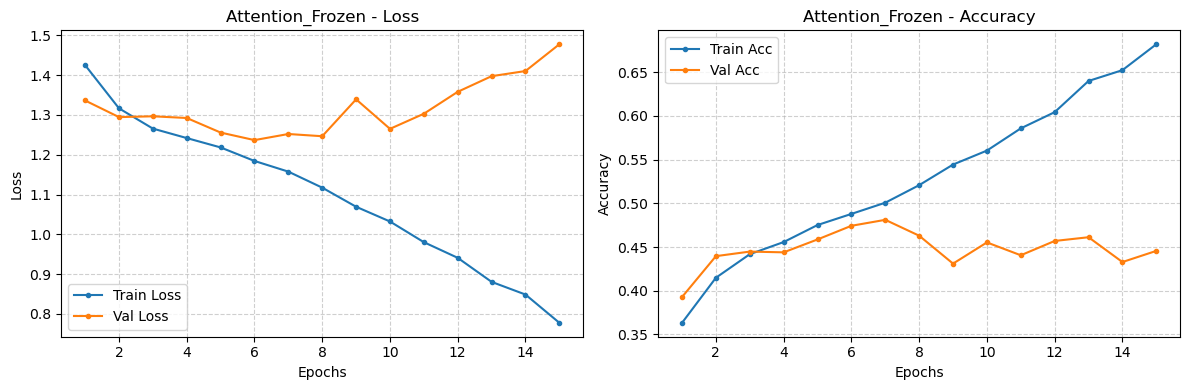

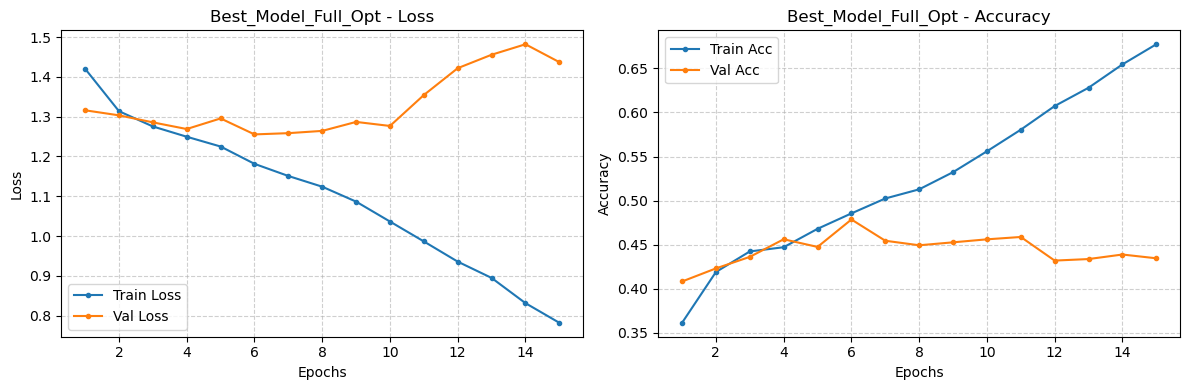

In [11]:
# --- Cell: Visualize and Report ---
print(f"Generating plots for {len(all_histories)} models...\n")

# You can adjust grid size or plotting logic here
for model_name, history in all_histories.items():
    Plotter.plot_history(history, title=model_name)

In [12]:
# Create and Display Dataframe
df_results = pd.DataFrame(all_summaries)

# Reorder columns for readability
cols = [
    "Model",
    "Type",
    "BiDir",
    "Embeds",
    "Best Val Acc",
    "Best Val Loss",
    "Time (s)",
    "Parameters",
]
# Filter to ensure columns exist before selecting
cols = [c for c in cols if c in df_results.columns]
df_results = df_results[cols + [c for c in df_results.columns if c not in cols]]

# Display Leaderboard
print("\n--- Experiment Leaderboard (Sorted by Validation Accuracy) ---")
display(df_results.sort_values(by="Best Val Acc", ascending=False))

# Export
csv_path = "sst_phase1_2_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")


--- Experiment Leaderboard (Sorted by Validation Accuracy) ---


,Model,Type,BiDir,Embeds,Best Val Acc,Best Val Loss,Time (s),Parameters,Layers,Train Loss,Train Acc,Val Loss,Val Acc
2,Attention_Frozen,LSTM,True,Pretrained,0.4811,1.2368,24.01,2722309,2,0.7776,0.6819,1.4778,0.4456
3,Best_Model_Full_Opt,LSTM,True,Pretrained,0.4786,1.2555,24.09,2722309,2,0.7822,0.6774,1.4370,0.4346
1,FineTuned_Embeddings,LSTM,True,Pretrained,0.4707,1.2423,24.28,2722309,2,0.7745,0.6888,1.4621,0.4398
0,Baseline_Winner,LSTM,True,Pretrained,0.4623,1.2657,24.20,2722309,2,0.7654,0.6860,1.5948,0.4258


Results saved to sst_phase1_2_results.csv
